In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import cv2
import matplotlib.pyplot as plt
import sys
import numpy as np
from skimage import segmentation
import torch.nn.init

In [22]:
args = {'nChannel':120, 'maxIter': 1500, 'minLabels': 2, 'lr': 0.1, 'nConv': 2, 'num_superpixels': 60000,
        'compactness': 100, 'visualize': True, 'input': '../data/256/0_1.jpeg'} # 'dog.jpeg' 'images/0_38.jpeg'
use_cuda = torch.cuda.is_available()

In [23]:
class MyNet(nn.Module):
    def __init__(self,input_dim):
        super(MyNet, self).__init__()
        self.conv1 = nn.Conv2d(input_dim, args['nChannel'], kernel_size=3, stride=1, padding=1 )
        self.bn1 = nn.BatchNorm2d(args['nChannel'])
        self.conv2 = nn.ModuleList()
        self.bn2 = nn.ModuleList()
        for i in range(args['nConv']-1):
            self.conv2.append( nn.Conv2d(args['nChannel'], args['nChannel'], kernel_size=3, stride=1, padding=1 ) )
            self.bn2.append( nn.BatchNorm2d(args['nChannel']) )
        self.conv3 = nn.Conv2d(args['nChannel'], args['nChannel'], kernel_size=1, stride=1, padding=0 )
        self.bn3 = nn.BatchNorm2d(args['nChannel'])

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu( x )
        x = self.bn1(x)
        for i in range(args['nConv']-1):
            x = self.conv2[i](x)
            x = F.relu( x )
            x = self.bn2[i](x)
        x = self.conv3(x)
        x = self.bn3(x)
        return x

In [24]:
im = cv2.imread(args['input'])
data = torch.from_numpy( np.array([im.transpose( (2, 0, 1) ).astype('float32')/255.]) )
if use_cuda:
    data = data.cuda()
data = Variable(data)
print(type(data), data.size())
# super pixels
labels = segmentation.slic(im, compactness=args['compactness'], n_segments=args['num_superpixels'])
print("Labels : ", type(labels), labels.shape)
labels = labels.reshape(im.shape[0]*im.shape[1])
print("Reshaped labels : ", labels.shape)
u_labels = np.unique(labels)
print("width labels : ", torch.min(torch.as_tensor(u_labels)), torch.max(torch.as_tensor(u_labels)))
print("Labels uniques ", len(u_labels))
labels_inds = []
for i in range(len(u_labels)):
    labels_inds.append(np.where(labels == u_labels[i])[0])

#torch.min(torch.as_tensor(l_inds)), torch.max(torch.as_tensor(l_inds))
print(len(labels_inds))

<class 'torch.Tensor'> torch.Size([1, 3, 256, 256])
Labels :  <class 'numpy.ndarray'> (256, 256)
Reshaped labels :  (65536,)
width labels :  tensor(1) tensor(65536)
Labels uniques  65536
65536


In [ ]:
# train
model = MyNet(data.size(1))
if use_cuda:
    model.cuda()
model.train()
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=args['lr'], momentum=0.9)
label_colours = np.random.randint(255,size=(args['nChannel'],3))
for batch_idx in range(args['maxIter']):
    # forwarding
    optimizer.zero_grad()
    output = model(data)[0]
    #print("Model output : ", output.shape, output)
    output = output.permute(1, 2, 0).flatten(0, 1)
    #print("Model output : ", output.shape, output) # (65536, 100)
    _, channel_max = torch.max(output, 1)
    #print(_.shape, channel_max.shape) # (65536, 1)
    channel_max = channel_max.data.cpu().numpy()
    nLabels = len(np.unique(channel_max))
    #print("Channels max : ", torch.min(torch.as_tensor(channel_max)), torch.max(torch.as_tensor(channel_max)), len(np.unique(channel_max)))
    
    for i in range(len(labels_inds)):
        labels_per_super_pixels = channel_max[labels_inds[i]]
        u_labels_per_sp = np.unique(labels_per_super_pixels)
        hist = np.zeros(len(u_labels_per_sp))
        for j in range(len(hist)):
            hist[j] = len(np.where(labels_per_super_pixels == u_labels_per_sp[j])[0])
        channel_max[labels_inds[i]] = u_labels_per_sp[np.argmax(hist)]
    #print("transformed Channels max : ", torch.min(torch.as_tensor(channel_max)), torch.max(torch.as_tensor(channel_max)), len(np.unique(channel_max)))
    target = torch.from_numpy(channel_max)
    if use_cuda:
        target = target.cuda()
    target = Variable(target)
    
    #print("Output : ", output.shape, torch.min(output).item(), torch.max(output).item(), output)
    #print(" Target : ", target.shape, torch.min(target).item(), torch.max(target).item(), target)
    
    loss = loss_fn(output, target)
    loss.backward()
    optimizer.step()

    if batch_idx % 100 == 0:
        print ('Epoch ', batch_idx, '/', args['maxIter'], ':', nLabels, loss.item())
        if args['visualize']:
            fig, axes = plt.subplots(nrows=1, ncols=2)
            for ax in axes:
                ax.grid(False)
                ax.axis('off')
            axes[0].imshow(im)
            im_target_rgb = np.array([label_colours[c % args['nChannel']] for c in channel_max]) # c is an index between 0 and args['nChannel]
            im_target_rgb = im_target_rgb.reshape(im.shape).astype(np.uint8)
            axes[1].imshow(im_target_rgb )
            plt.show()
    
    if nLabels < args['minLabels']:
        print ("nLabels", nLabels, "reached minLabels", args['minLabels'], ".")
        break

In [ ]:

def show_mask(masks, ax, random_color=False):    
    h, w = masks.shape[-2:]
    for mask in masks:
        if random_color:
            color = np.concatenate([np.random.random(3), np.array([0.3])], axis=0)
        else:
            color = np.array([30/255, 144/255, 255/255, 0.5])
        mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
        ax.imshow(mask_image)

In [ ]:
def get_bounding_boxes(masks):
    bounding_boxes = []
    for i in range(masks.shape[0]):
        mask = masks[i]
        if np.any(mask):
            x,y,w,h = cv2.boundingRect(mask)
            rows = np.any(mask, axis=1)
            cols = np.any(mask, axis=0)
            rmin, rmax = np.where(rows)[0][[0, -1]]
            cmin, cmax = np.where(cols)[0][[0, -1]]
            bounding_boxes.append((i, (rmin, cmin, rmax, cmax)))
    return bounding_boxes

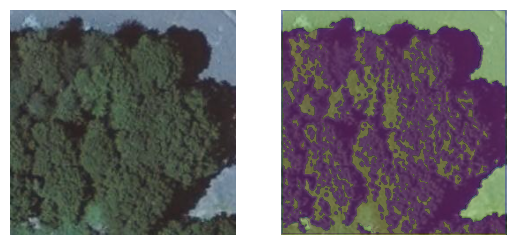

In [ ]:
INFERENCE_PATH = "predict"

if args['visualize']:
    output = model(data)[0]
    output = output.permute(1, 2, 0)#.flatten(0, 1)
    _, classes = torch.max(output, 2)
    t_classes = classes.data.cpu().numpy()
    #print("Classes ", t_classes.shape)
    unique_classes = np.unique(t_classes)
    #print("Classes uniques ", unique_classes.shape, unique_classes)
    nClasses = len(unique_classes)
    
    masks = np.zeros(shape=(nClasses, *im.shape[:2]))
    #print("Masks ", masks.shape)
    for i, cls in enumerate(unique_classes):
        pixels_ind_for_mask_i = np.argwhere(t_classes == cls)
        #print("Indices shape ", pixels_ind_for_mask_i.shape)
        if len(pixels_ind_for_mask_i) >= 200:  # minimal pixel surface of a tree          
            masks[i, pixels_ind_for_mask_i[:, 0], pixels_ind_for_mask_i[:, 1]] = 1
    masks = (masks > 0).astype(float)

    fig, axes = plt.subplots(nrows=1, ncols=2)
    for ax in axes:
        ax.grid(False)
        ax.axis('off')
    msk = im.copy()

    axes[0].imshow(im)
    axes[1].imshow(msk)
    show_mask(masks, axes[1], True)
plt.imsave("output.png", im_target_rgb)